In [1]:
import pandas as pd
import geopandas as gpd
from siuba import *

import dask.dataframe as dd

from segment_speed_utils import helpers
from segment_speed_utils.project_vars import SEGMENT_GCS, analysis_date

import intake

In [2]:
from calitp_data_analysis import geography_utils

# Add interpolated segments to pipeline

* Additional detail between widely spaced stops is more useful for speed analysis

## Check existing segments

In [3]:
# cat = intake.open_catalog('catalog.yml')

In [4]:
# cat.stop_segments.read()

In [5]:
path = 'gs://calitp-analytics-data/data-analyses/rt_segment_speeds/segment_options/stop_segments_2024-03-13.parquet'

In [6]:
#  read via geopandas so that geometry stays intact
# segs = gpd.read_parquet(path)

In [7]:
# segs >> head(3)

In [8]:
# segs >> filter(_.shape_array_key == '37bb198ccd3af93e3b7f10bb7602faff') >> count(_.trip_instance_key)

In [9]:
segs.length.quantile(.94)

NameError: name 'segs' is not defined

In [10]:
# segs >> count(_.segment_id) >> arrange(-_.n)

In [11]:
# (segs >> filter(_.segment_id == '5138-7345-1')).explore()

In [12]:
segs_ddf = dd.from_pandas(segs, npartitions=50)

In [13]:
segs_ddf = segs_ddf.assign(length=lambda x: x.geometry.length)

In [14]:
next_sequence_ddf = segs_ddf[['trip_instance_key', 'stop_sequence']].groupby('trip_instance_key').shift(-1)
next_sequence_ddf = next_sequence_ddf.rename(columns={'stop_sequence': 'next_stop_sequence'})

/tmp/ipykernel_1311/231179082.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .shift(1)
  After:  .shift(1, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .shift(1, meta=('x', 'f8'))            for series result
  next_sequence_ddf = segs_ddf[['trip_instance_key', 'stop_sequence']].groupby('trip_instance_key').shift(-1)


In [15]:
#  note this relies on the index
segs_ddf = segs_ddf.join(next_sequence_ddf)

In [16]:
# !mkdir test_segs

In [17]:
segs_ddf[['next_stop_sequence', 'length']].to_parquet('test_segs/')

In [ ]:
# new_cols = segs_ddf.compute()

In [7]:
segs_ddf = dd.read_parquet('test_segs/')

In [9]:
segs_ddf

,next_stop_sequence,length
npartitions=50,,
,float64,float64
,...,...
...,...,...
,...,...
,...,...


In [14]:
#  restart kernel/seperate script

In [10]:
segs = segs.join(segs_ddf.compute())

In [11]:
segs.to_parquet('test_interpolated_segs.parquet')

In [10]:
segs = gpd.read_parquet('test_interpolated_segs.parquet')

In [11]:
segs

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
0,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,178,0,"LINESTRING (194586.662 -428941.623, 194587.395...",1240,178-1240-1,178__1240,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,108.0,784.479410
1,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,1240,108,"LINESTRING (195357.813 -428903.011, 195357.813...",1323,1240-1323-1,1240__1323,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,168.0,451.539008
2,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,1323,168,"LINESTRING (195809.164 -428891.931, 195809.164...",1248,1323-1248-1,1323__1248,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,212.0,336.126184
3,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,1248,212,"LINESTRING (196145.009 -428880.735, 196145.009...",1604,1248-1604-1,1248__1604,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,274.0,464.086838
4,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,1604,274,"LINESTRING (196182.624 -429313.952, 196182.624...",1639,1604-1639-1,1604__1639,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,335.0,459.621199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2981607,ff8a70473d109c68b3167c54d312a1f3,5eda300e8c7f463886ec421e7eab9dd9,12687,104,"LINESTRING (142081.670 -447712.691, 142079.341...",12686,12687-12686-1,12687__12686,3f3f36b4c41cc6b5df3eb7f5d8ea6e3c,108-13172,1.0,105.0,288.310052
2981608,ff8a70473d109c68b3167c54d312a1f3,5eda300e8c7f463886ec421e7eab9dd9,12686,105,"LINESTRING (141920.267 -447473.813, 141920.267...",16524,12686-16524-1,12686__16524,3f3f36b4c41cc6b5df3eb7f5d8ea6e3c,108-13172,1.0,106.0,280.442491
2981609,ff8a70473d109c68b3167c54d312a1f3,5eda300e8c7f463886ec421e7eab9dd9,16524,106,"LINESTRING (141808.208 -447247.351, 141808.208...",16527,16524-16527-1,16524__16527,3f3f36b4c41cc6b5df3eb7f5d8ea6e3c,108-13172,1.0,107.0,67.477146
2981610,ff8a70473d109c68b3167c54d312a1f3,5eda300e8c7f463886ec421e7eab9dd9,16527,107,"LINESTRING (141861.867 -447206.450, 141870.863...",16528,16527-16528-1,16527__16528,3f3f36b4c41cc6b5df3eb7f5d8ea6e3c,108-13172,1.0,108.0,406.977833


## Find BBBR10

In [27]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

from calitp_data_analysis.tables import tbls
from shared_utils import gtfs_utils_v2

In [24]:
bbb = gtfs_utils_v2.schedule_daily_feed_to_gtfs_dataset_name('2024-03-13') >> filter(_.name.str.contains('Big Blue'))

In [25]:
bbb

,key,date,feed_key,feed_timezone,base64_url,gtfs_dataset_key,gtfs_dataset_name,type,name,regional_feed_type
219,c35ae2a7cb1f9ad2cf0a5bce84ccf298,2024-03-13,4f9888472a8dad0f66bdbbd002312789,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,efbbd5293be71f7a5de0cf82b59febe1,Big Blue Bus Schedule,schedule,Big Blue Bus Schedule,None


In [40]:
bbbr10 = (tbls.mart_gtfs.fct_scheduled_trips()
 >> filter(_.gtfs_dataset_key.isin(bbb.gtfs_dataset_key),
          _.route_short_name.str.contains('R10'),
          _.service_date == '2024-03-13')
) >> collect()

In [41]:
bbbr10

,key,trip_instance_key,feed_timezone,base64_url,name,regional_feed_type,gtfs_dataset_key,service_date,feed_key,service_id,...,trip_last_arrival_datetime_pacific,trip_start_date_local_tz,trip_first_departure_datetime_local_tz,trip_last_arrival_datetime_local_tz,trip_first_start_pickup_drop_off_window_date_pacific,trip_first_start_pickup_drop_off_window_datetime_pacific,trip_last_end_pickup_drop_off_window_pacific,trip_first_start_pickup_drop_off_window_date_local_tz,trip_first_start_pickup_drop_off_window_datetime_local_tz,trip_last_end_pickup_drop_off_window_datetime_local_tz
0,90db8c72792ec17cbfbcea25c4755ee1,d98e5cc1fb62e6e5ed0030934ef8a396,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 06:48:33,2024-03-13,2024-03-13 06:00:00,2024-03-13 06:48:33,None,None,None,None,None,None
1,3fe37ab5b4a46d3be38536059411b341,3505bf6a20e8d29e83e545784a421bc7,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 08:09:24,2024-03-13,2024-03-13 07:00:00,2024-03-13 08:09:24,None,None,None,None,None,None
2,89f1fb4c504b72d70209787272cdf30e,c3577c96a714df975f5525b246987e41,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 09:22:20,2024-03-13,2024-03-13 08:04:00,2024-03-13 09:22:20,None,None,None,None,None,None
3,f0853c83ae28356bf98795ffd26bf2b6,f1866ab43b90dd43adb557fe527177d2,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 16:35:00,2024-03-13,2024-03-13 15:35:00,2024-03-13 16:35:00,None,None,None,None,None,None
4,9688636df1f105e304939f80869ff475,8a452661390b69cd00fdcde92066cc4a,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 18:29:00,2024-03-13,2024-03-13 17:05:00,2024-03-13 18:29:00,None,None,None,None,None,None
5,ca6cc33527b7e8079279008ed55b09af,5d3dc572ce27ef902024f6f135cf59c2,America/Los_Angeles,aHR0cDovL2d0ZnMuYmlnYmx1ZWJ1cy5jb20vY3VycmVudC...,Big Blue Bus Schedule,None,efbbd5293be71f7a5de0cf82b59febe1,2024-03-13,4f9888472a8dad0f66bdbbd002312789,10,...,2024-03-13 19:15:00,2024-03-13,2024-03-13 18:05:00,2024-03-13 19:15:00,None,None,None,None,None,None


## Work out function

In [12]:
import shapely

In [13]:
shapely.__version__

'2.0.1'

In [14]:
test = segs >> filter(_.trip_instance_key == '3505bf6a20e8d29e83e545784a421bc7')

In [15]:
long = test >> filter(_.stop_sequence == 18)

In [16]:
geom = long.geometry.iloc[0]

In [17]:
geom.length

17696.81706739369

In [18]:
km_segs = geom.length // 1000
km_segs

17.0

In [19]:
def split_distance(geom, dist=1000):
    '''
    geom: shapely.LineString
    
    returns a shapely.MultiLineString split every dist (meters)
    '''
    
    split_segs = geom.length // dist
    substrings = []
    for i in range(0, int(split_segs)):
        substrings += [shapely.ops.substring(geom, i * dist, (i+1) * dist)]
    substrings += [shapely.ops.substring(geom, split_segs * dist, geom.length)]
    new_geom = shapely.MultiLineString(substrings)
    
    return new_geom

In [20]:
new_geom = split_distance(geom)

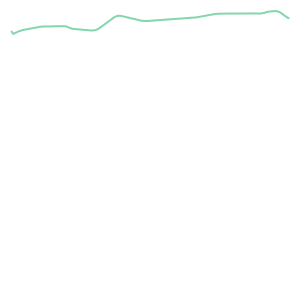

In [21]:
geom

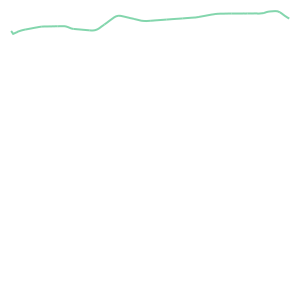

In [22]:
new_geom

In [23]:
# geom.wkt

In [24]:
# new_geom.wkt

In [25]:
long.geometry = [new_geom]

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
exploded = long.explode()

/tmp/ipykernel_370/1845589243.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = long.explode()


In [27]:
#  note order remains from list order passed to MultiLineString constructor
exploded

trip_instance_key  \
2875405 0   3505bf6a20e8d29e83e545784a421bc7   
        1   3505bf6a20e8d29e83e545784a421bc7   
        2   3505bf6a20e8d29e83e545784a421bc7   
        3   3505bf6a20e8d29e83e545784a421bc7   
        4   3505bf6a20e8d29e83e545784a421bc7   
        5   3505bf6a20e8d29e83e545784a421bc7   
        6   3505bf6a20e8d29e83e545784a421bc7   
        7   3505bf6a20e8d29e83e545784a421bc7   
        8   3505bf6a20e8d29e83e545784a421bc7   
        9   3505bf6a20e8d29e83e545784a421bc7   
        10  3505bf6a20e8d29e83e545784a421bc7   
        11  3505bf6a20e8d29e83e545784a421bc7   
        12  3505bf6a20e8d29e83e545784a421bc7   
        13  3505bf6a20e8d29e83e545784a421bc7   
        14  3505bf6a20e8d29e83e545784a421bc7   
        15  3505bf6a20e8d29e83e545784a421bc7   
        16  3505bf6a20e8d29e83e545784a421bc7   
        17  3505bf6a20e8d29e83e545784a421bc7   

                             shape_array_key stop_id1  stop_sequence stop_id2  \
2875405 0   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        1   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        2   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        3   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        4   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        5   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        6   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        7   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        8   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        9   37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        10  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        11  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        12  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        13  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        14  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        15  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        16  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   
        17  37468c4ffbbbab83f270b8fcecb6de61      228             18      106   

           segment_id stop_pair         schedule_gtfs_dataset_key route_id  \
2875405 0   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        1   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        2   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        3   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        4   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        5   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        6   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        7   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        8   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        9   228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        10  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        11  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        12  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        13  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        14  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        15  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        16  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        17  228-106-1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   

            direction_id  next_stop_sequence        length  \
2875405 0            0.0     

In [28]:
import numpy as np

In [29]:
def process_exploded(gdf):
    '''
    update required cols in exploded gdf
    
    stop_sequence: add decimal proportional to segment distance
    segment_id: postfix _(int) per segment to maintain uniqueness
    '''
    gdf.length = gdf.geometry.apply(lambda x: x.length)
    
    min_stop = int(gdf.stop_sequence.min())
    next_stop = int(gdf.next_stop_sequence.max())
    stop_seq_chg = gdf.next_stop_sequence.max() - min_stop
    
    #  increment stop sequence proportional to distance traveled 
    seq_per_km = stop_seq_chg / gdf.length.sum() 
    seq_changes = gdf.length * seq_per_km
    stop_sequences_scaled = np.flip(next_stop - np.flip(seq_changes).cumsum())
    
    gdf.stop_sequence = stop_sequences_scaled
    
    #  postfix to segment_id so that it remains unique
    postfixes = np.arange(0, gdf.shape[0]).astype(str)
    underscores = np.full(gdf.shape[0], '_')
    postfixes = np.char.add(underscores, postfixes)
    gdf.segment_id = gdf.segment_id + postfixes
    
    return(gdf)

In [30]:
processed = process_exploded(exploded)

In [31]:
from shared_utils.rt_utils import arrowize_segment

In [32]:
arrowize_segment?

Signature: arrowize_segment(line_geometry, buffer_distance: int = 20)
Docstring:
Given a linestring segment from a gtfs shape,
buffer and clip to show direction of progression
File:      ~/data-analyses/_shared_utils/shared_utils/rt_utils.py
Type:      function

In [33]:
processed.geometry = processed.geometry.apply(lambda x: arrowize_segment(x))

In [34]:
processed

trip_instance_key  \
2875405 0   3505bf6a20e8d29e83e545784a421bc7   
        1   3505bf6a20e8d29e83e545784a421bc7   
        2   3505bf6a20e8d29e83e545784a421bc7   
        3   3505bf6a20e8d29e83e545784a421bc7   
        4   3505bf6a20e8d29e83e545784a421bc7   
        5   3505bf6a20e8d29e83e545784a421bc7   
        6   3505bf6a20e8d29e83e545784a421bc7   
        7   3505bf6a20e8d29e83e545784a421bc7   
        8   3505bf6a20e8d29e83e545784a421bc7   
        9   3505bf6a20e8d29e83e545784a421bc7   
        10  3505bf6a20e8d29e83e545784a421bc7   
        11  3505bf6a20e8d29e83e545784a421bc7   
        12  3505bf6a20e8d29e83e545784a421bc7   
        13  3505bf6a20e8d29e83e545784a421bc7   
        14  3505bf6a20e8d29e83e545784a421bc7   
        15  3505bf6a20e8d29e83e545784a421bc7   
        16  3505bf6a20e8d29e83e545784a421bc7   
        17  3505bf6a20e8d29e83e545784a421bc7   

                             shape_array_key stop_id1  stop_sequence stop_id2  \
2875405 0   37468c4ffbbbab83f270b8fcecb6de61      228      18.000000      106   
        1   37468c4ffbbbab83f270b8fcecb6de61      228      18.056507      106   
        2   37468c4ffbbbab83f270b8fcecb6de61      228      18.113015      106   
        3   37468c4ffbbbab83f270b8fcecb6de61      228      18.169522      106   
        4   37468c4ffbbbab83f270b8fcecb6de61      228      18.226029      106   
        5   37468c4ffbbbab83f270b8fcecb6de61      228      18.282537      106   
        6   37468c4ffbbbab83f270b8fcecb6de61      228      18.339044      106   
        7   37468c4ffbbbab83f270b8fcecb6de61      228      18.395551      106   
        8   37468c4ffbbbab83f270b8fcecb6de61      228      18.452059      106   
        9   37468c4ffbbbab83f270b8fcecb6de61      228      18.508566      106   
        10  37468c4ffbbbab83f270b8fcecb6de61      228      18.565073      106   
        11  37468c4ffbbbab83f270b8fcecb6de61      228      18.621581      106   
        12  37468c4ffbbbab83f270b8fcecb6de61      228      18.678088      106   
        13  37468c4ffbbbab83f270b8fcecb6de61      228      18.734595      106   
        14  37468c4ffbbbab83f270b8fcecb6de61      228      18.791103      106   
        15  37468c4ffbbbab83f270b8fcecb6de61      228      18.847610      106   
        16  37468c4ffbbbab83f270b8fcecb6de61      228      18.904117      106   
        17  37468c4ffbbbab83f270b8fcecb6de61      228      18.960625      106   

              segment_id stop_pair         schedule_gtfs_dataset_key route_id  \
2875405 0    228-106-1_0  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        1    228-106-1_1  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        2    228-106-1_2  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        3    228-106-1_3  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        4    228-106-1_4  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        5    228-106-1_5  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        6    228-106-1_6  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        7    228-106-1_7  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        8    228-106-1_8  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        9    228-106-1_9  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        10  228-106-1_10  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        11  228-106-1_11  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        12  228-106-1_12  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        13  228-106-1_13  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        14  228-106-1_14  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        15  228-106-1_15  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        16  228-106-1_16  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   
        17  228-106-1_17  228__106  efbbd5293be71f7a5de0cf82b59febe1     3714   

            direction_id  next_sto

In [35]:
# processed.explore()

## Abstracting -- drop long geoms from overall, process as array of gdfs, merge?

In [41]:
shorts = (segs[segs['length'] < 1000]).copy()

In [42]:
longs = (segs[segs['length'] > 1000]).copy()

In [44]:
# longs

In [50]:
test_longs = longs.iloc[:1000,:]

In [52]:
test_longs.head(3)

,trip_instance_key,shape_array_key,stop_id1,stop_sequence,geometry,stop_id2,segment_id,stop_pair,schedule_gtfs_dataset_key,route_id,direction_id,next_stop_sequence,length
22,0000dbb743b258f707687f2dc14ad90f,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963
78,09e32488392ad4c1684b0108f3bba8b3,37bb198ccd3af93e3b7f10bb7602faff,819,1532,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1767.0,1734.469963
134,0aaeb33101f4ac9ebb7851388c355825,37bb198ccd3af93e3b7f10bb7602faff,819,1672,"LINESTRING (195533.932 -435807.899, 195532.071...",2304,819-2304-1,819__2304,f74424acf8c41e4c1e9fd42838c4875c,488,1.0,1959.0,1734.469963


### Rowwise apply and accumulate?

In [53]:
interpolated_longs = []

In [ ]:
def interpolate_segments(row):
    '''
    
    '''
    global interpolated_longs
    new_geom = split_distance(row.geometry)
    row.geometry = new_geom
    
    #  back to gdf to use GeoDataFrame.explode()
    gdf_row = gpd.GeoDataFrame(row)